In [1]:
import numpy as np
import pandas as pd
import os
import spacy
import nltk
from afinn import Afinn
import itertools
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import networkx as nx


In [2]:
def get_common_english_words(path):
    words = []
    with open(path) as f:
        for word in f.readlines():
            words.append(word.strip())

    return words

def read_text(path):
    with open(path) as f:
        text = f.read().replace('\r', ' ').replace('\n', ' ').replace("\'", "'")

    return text

In [3]:
def NER(s):
    named_entities = []
    accepted_labels = ['PERSON']
    entities = nlp(s).ents
    for e in entities:
        if e.label_ in accepted_labels:
            named_entities.append(str(e).lower().replace("'s", "").split(' '))

    return list(itertools.chain(*named_entities))

In [4]:
def get_named_entities(sentences):
    threshold = 0.0001
    named_entities = []
    named_entities_thresholded = []
    for s in sentences:
        named_entities += NER(s)

    named_entities = [ne for ne in named_entities if ne not in common_english_words]
    named_entities = Counter(named_entities)
    for ne in named_entities:
        if named_entities[ne] >= threshold * len(sentences):
            named_entities_thresholded.append(ne)

    return named_entities_thresholded

In [5]:
def get_main_characters(book, characters, number_of_characters):
    cv = CountVectorizer(vocabulary=characters, stop_words='english')
    freq = cv.fit_transform([book.lower()])
    freq = pd.DataFrame(freq.toarray(), columns=cv.get_feature_names())
    freq = freq.T
    freq = freq.sort_values(by=0, ascending=False)
    freq = freq[0:number_of_characters]

    characters = list(freq.index)
    return freq, characters

In [6]:
def get_mtx(sentences, main_characters):
    afinn = Afinn()
    score = [afinn.score(s) for s in sentences]
    alignment = np.sum(score) / len(np.nonzero(score)[0]) * (-2)

    nc = CountVectorizer(vocabulary=main_characters, binary=True)
    freq = nc.fit_transform(sentences).toarray()

    sentiment_mtx = np.dot(freq.T, (freq.T * score).T)
    cooccur_mtx = np.dot(freq.T, freq)

    sentiment_mtx += alignment * cooccur_mtx
    sentiment_mtx, cooccur_mtx = np.tril(sentiment_mtx), np.tril(cooccur_mtx)

    cooccur_mtx[[range(cooccur_mtx.shape[0])], [range(cooccur_mtx.shape[0])]] = 0
    sentiment_mtx[[range(sentiment_mtx.shape[0])], [range(sentiment_mtx.shape[0])]] = 0

    return sentiment_mtx, cooccur_mtx



In [7]:
def plot_graph(name_list, name_frequency, matrix, plt_name, mode, path=''):
    '''
    Function to plot the network graph (co-occurrence network or sentiment network).
    :param name_list: the list of top character names in the novel.
    :param name_frequency: the list containing the frequencies of the top names.
    :param matrix: co-occurrence matrix or sentiment matrix.
    :param plt_name: the name of the plot (PNG file) to output.
    :param mode: 'co-occurrence' or 'sentiment'
    :param path: the path to output the PNG file.
    :return: a PNG file of the network graph.
    '''

    label = {i: i for i in name_list}
    edge_list = matrix_to_edge_list(matrix, mode, name_list)
    normalized_frequency = np.array(name_frequency) / np.max(name_frequency)

    plt.figure(figsize=(20, 20))
    G = nx.Graph()
    G.add_nodes_from(name_list)
    G.add_edges_from(edge_list)
    pos = nx.circular_layout(G)
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    colors = [G[u][v]['color'] for u, v in edges]

    if mode == 'co-occurrence':
        nx.draw(G, pos, node_color='#A0CBE2', node_size=np.sqrt(normalized_frequency) * 4000, edge_cmap=plt.cm.Blues,
                linewidths=10, font_size=35, labels=label, edge_color=colors, with_labels=True, width=weights)
    elif mode == 'sentiment':
        nx.draw(G, pos, node_color='#A0CBE2', node_size=np.sqrt(normalized_frequency) * 4000,
                linewidths=10, font_size=35, labels=label, edge_color=colors, with_labels=True,
                width=weights, edge_vmin=-1000, edge_vmax=1000)
    else:
        raise ValueError("mode should be either 'co-occurrence' or 'sentiment'")

    plt.savefig(path + plt_name + '.png')

In [8]:
def matrix_to_edge_list(matrix, mode, name_list):
    '''
    Function to convert matrix (co-occurrence/sentiment) to edge list of the network graph. It determines the
    weight and color of the edges in the network graph.
    :param matrix: co-occurrence matrix or sentiment matrix.
    :param mode: 'co-occurrence' or 'sentiment'
    :param name_list: the list of names of the top characters in the novel.
    :return: the edge list with weight and color param.
    '''
    edge_list = []
    shape = matrix.shape[0]
    lower_tri_loc = list(zip(*np.where(np.triu(np.ones([shape, shape])) == 0)))
    normalized_matrix = matrix / np.max(np.abs(matrix))
    if mode == 'co-occurrence':
        weight = np.log(2000 * normalized_matrix + 1) * 0.7
        color = np.log(2000 * normalized_matrix + 1)
    if mode == 'sentiment':
        weight = np.log(np.abs(1000 * normalized_matrix) + 1) * 0.7
        color = 2000 * normalized_matrix
    for i in lower_tri_loc:
        edge_list.append((name_list[i[0]], name_list[i[1]], {'weight': weight[i], 'color': color[i]}))

    return edge_list

In [10]:
nlp = spacy.load('en_core_web_sm')
common_english_words = get_common_english_words('data/common_english_words.txt')
book = read_text('data/common_english_words.txt')
sentences = nltk.sent_tokenize(book)
characters = get_named_entities(sentences)
freq, main_characters = get_main_characters(book, characters, number_of_characters=25)
sentiment_mtx, cooccur_mtx = get_mtx(sentences, main_characters)

FileNotFoundError: [Errno 2] No such file or directory: 'data/common_english_words.txt'

In [10]:
temp = freq.values
temp = temp.tolist()
freq = [item for sublist in temp for item in sublist]

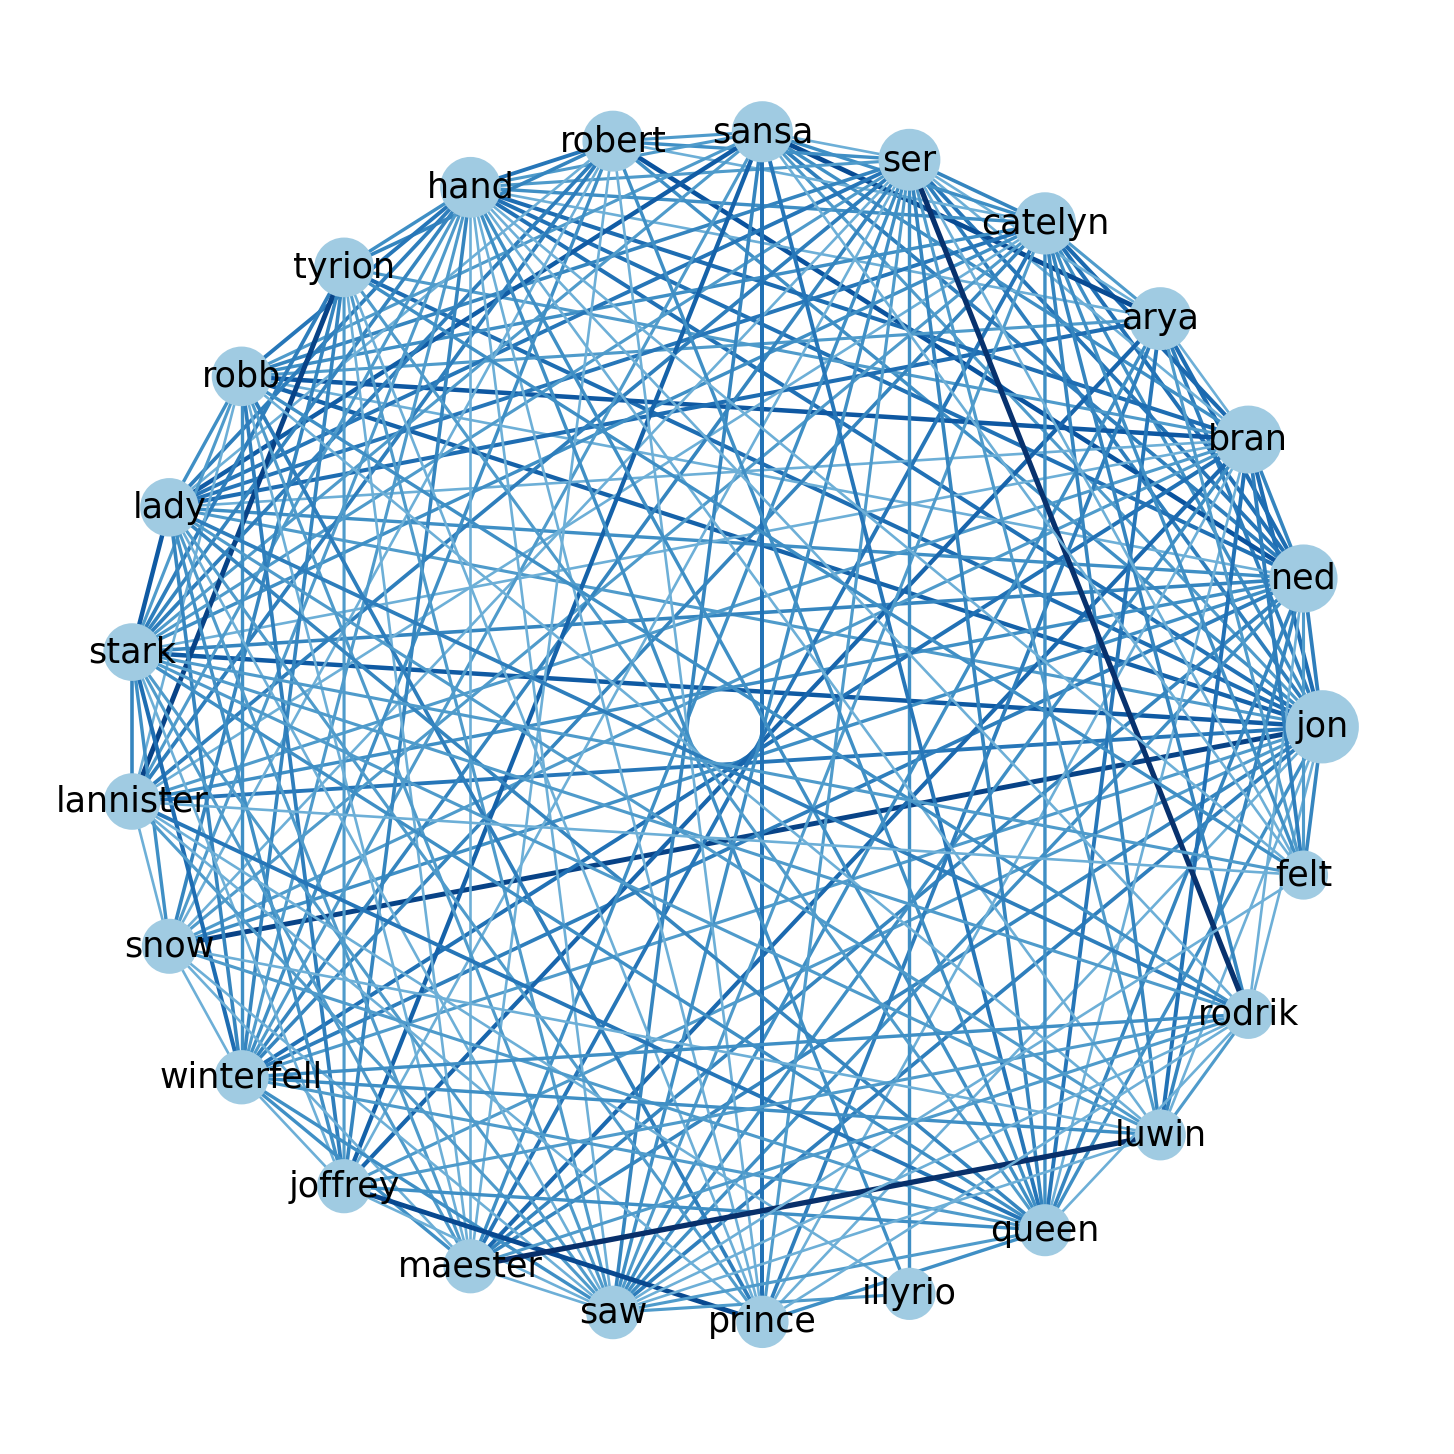

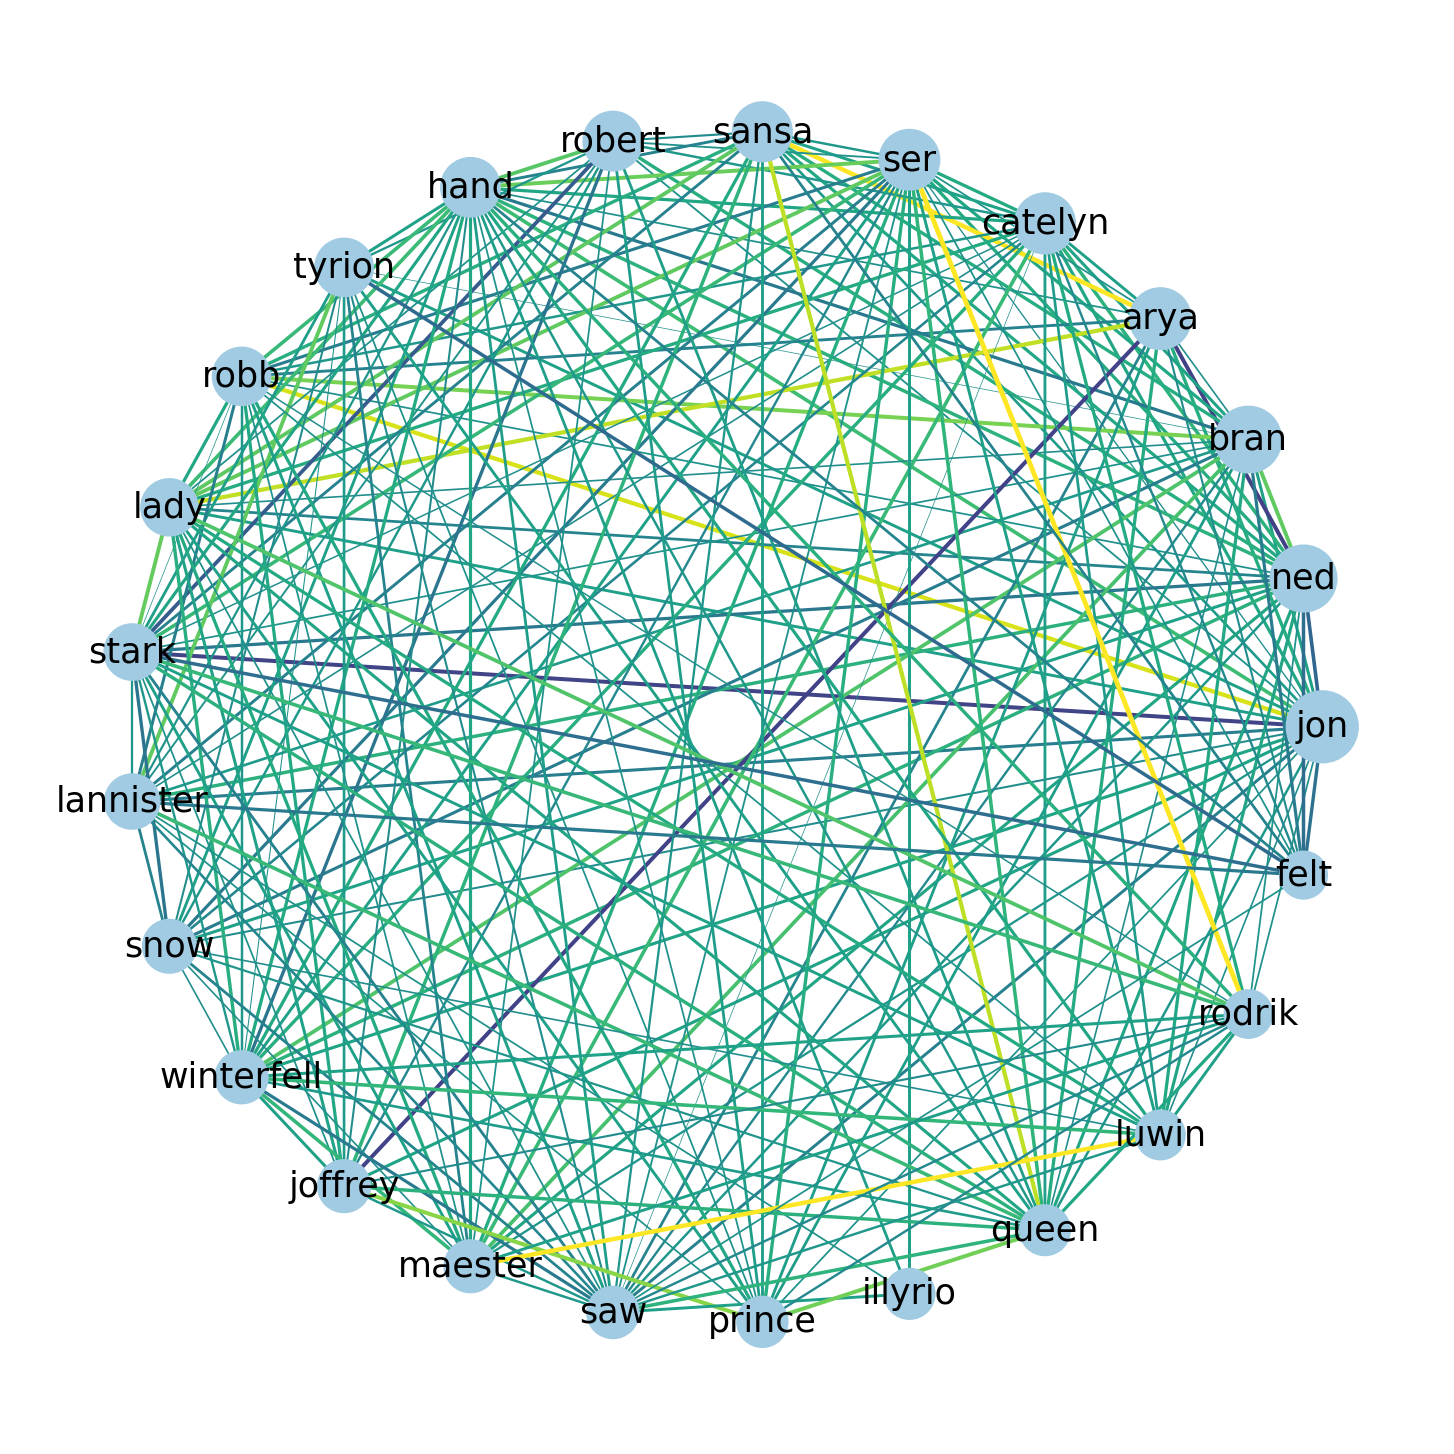

In [11]:
plot_graph(main_characters, freq, cooccur_mtx, "test" + ' co-occurrence graph', 'co-occurrence')
plot_graph(main_characters, freq, sentiment_mtx, "test" + ' sentiment graph', 'sentiment')